# Assignment 2 - Atharva Niranjan Joshi - 200425197

## Question 1 

In [1]:
import os
import sys
from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np
import re
import unicodedata

##### Imported the relevant libraries 

In [2]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []
    current_sent = []
    for line in f:
        if line == "\n":
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

##### Defined a function where we extract the data from the bio files. It is done in a way that is matches the way data is stored in the file. 

In [3]:
file_data_train = get_raw_data_from_bio_file("engtrain.bio.txt")
from sklearn.model_selection import train_test_split
train_data_new, development_data_new = train_test_split(file_data_train, train_size=0.8, shuffle=False)

##### Extracted data from the engtrain bio text file using the function defined above.
##### Here we saw that we split the training dataset into two datasets each 80% and 20% of the original dataset. We used the train_test_split function from the sklearn library. We could've also calculated the length of the dataset, multiplied it by 0.8 and then sliced the dataset like follows:
##### splitSize = len(training_data)*0.8
##### new_train_set = training_data[:splitSize]
##### new_development_set = training_data[splitSize:]

In [4]:
print(file_data_train[0])
print(train_data_new[0])
print(development_data_new[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('five', 'B-RATINGS_AVERAGE'), ('star', 'O'), ('rated', 'O'), ('thriller', 'B-GENRE'), ('directed', 'O'), ('by', 'O'), ('dover', 'B-DIRECTOR'), ('koshashvili', 'I-DIRECTOR'), ('is', 'O'), ('unrated', 'B-RATING')]


##### Saw the first data to get an idea what it looks like

In [5]:
print('Full Data:')
print(len(file_data_train), "instances")
print(sum([len(sent) for sent in file_data_train]), "words")
print('Split training Data:')
print(len(train_data_new), "instances")
print(sum([len(sent) for sent in train_data_new]), "words")
print('Split test Data:')
print(len(development_data_new), "instances")
print(sum([len(sent) for sent in development_data_new]), "words")

Full Data:
9775 instances
99491 words
Split training Data:
7820 instances
79266 words
Split test Data:
1955 instances
20225 words


##### Looked at some properties of the datasets (Full and split)

In [6]:
def preProcess(example):
    preprocessed_example = example
    return preprocessed_example

##### Here we did not do any preprocessing since we already have the data in the form we want [('word', 'IOB_Tag')]

In [7]:
train_data_full = [preProcess(example) for example in file_data_train]
train_data_split = [preProcess(example) for example in train_data_new]

##### Applying the preprocessing techniques on the full and split train dataset

In [8]:
print(train_data_full[0])
print(train_data_split[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


##### Seeing the preprocessed data

In [9]:
_pattern = re.compile(r"\d")
def get_features(tokens, idx):
    token = tokens[idx]
    feature_list = []
    if not token:
        return feature_list
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")
    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")
    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])        
    feature_list.append("WORD_" + token)
    return feature_list

##### Above, we have added some features to the words to establish relationship and make the more discernable. 
##### Following are the features we used:
##### 1) CAPITALIZATION
##### Whenever the first letter of any word is a capital letter annotated using 'CAPITALIZATION'
##### 2) HAS_NUM
##### Whenever any string has a number in it annotated using 'HAS_NUM'
##### 3) PUNCTUATION
##### All punctuation marks are annotated using 'PUNCTUATION'
##### 4) SUF_ (upto length 3)
##### All words' suffixes with length upto 3 are annotated using 'SUF_'
##### 5) WORD_
##### All words are annotated using 'WORD_'

### Training the Full Train Dataset 

In [10]:
TAGGER_PATH = "crf_nlu_full.tagger"  
ct = CRFTagger(feature_func=get_features)  
ct.train(train_data_full, TAGGER_PATH)
print("done")

done


##### Training the CRF Tagger on the full dataset

### Testing on the Full Test Dataset 

In [11]:
ct = CRFTagger(feature_func=get_features)
ct.set_model_file(TAGGER_PATH)
file_data_test = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data_full = [preProcess(example) for example in file_data_test]
print(len(test_data_full), "instances")
print(sum([len(sent) for sent in test_data_full]), "words")

2443 instances
24686 words


##### Here we extracted the test data set from the file, preprocessed it and analyzed it's basic information.

In [12]:
print("testing tagger...")
preds_full = []
y_test_full = []
for sent in test_data_full:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_full.extend(sent_preds)
    y_test_full.extend(sent_true)
print("done")

testing tagger...
done


##### We then tested that test data on the CRF Tagger we just trained.

### Storing the Classification Report and Heatmap

In [13]:
def confusion_matrix_heatmap(y_test, preds):
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

##### Defined the function to display the confusion matrix heatmap.

In [14]:
full_classification_report = classification_report(y_test_full, preds_full, zero_division = 1)
#Used zero_division parameter because of the warning

##### Created and stored the classification report for the full dataset.

### Training the Split Train Dataset

In [15]:
TAGGER_PATH = "crf_nlu_split.tagger"  
ct = CRFTagger(feature_func=get_features)  
ct.train(train_data_split, TAGGER_PATH)
print("done")

done


##### Now we train the CRF Tagger on the split training set.

### Testing on the split Development Dataset 

In [16]:
development_data_split =[preProcess(example) for example in development_data_new]

##### Applied preprocessing to the development dataset.

In [17]:
print("testing tagger...")
preds_split = []
y_test_split = []
for sent in development_data_split:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_split.extend(sent_preds)
    y_test_split.extend(sent_true)
print("done")

testing tagger...
done


##### Testing the Preprocessed Development dataset on the trained CRF Tagger.

### Storing the split classification Report

In [18]:
split_classification_report = classification_report(y_test_split, preds_split, zero_division = 1)
#Used zero_division parameter because of the warning

##### Created and stored the classification report for the split dataset.

### Comparing both Reports and their corresponding heatmaps

#### Full Dataset Classification Report

In [19]:
print(full_classification_report)

                   precision    recall  f1-score   support

          B-ACTOR       0.76      0.88      0.81       812
      B-CHARACTER       0.72      0.26      0.38        90
       B-DIRECTOR       0.77      0.61      0.68       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.60      0.40      0.48       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.87      0.82      0.84       451
         B-REVIEW       0.14      0.02      0.03        56
           B-SONG       0.69      0.17      0.27        54
          B-TITLE       0.58      0.50      0.54       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.75      0.89      0.81       862
      I-CHARACTER       0.76      0.29      0.42        75
       I-DIRECTOR       0.78      0.60      0.68       496
          I-GENRE       0.84      0.71      0.77       

#### Heat Map of full Dataset 

C:\Users\athar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-GENRE', 'I-RATING', 'B-RATING', 'I-CHARACTER', 'B-SONG', 'B-CHARACTER', 'B-YEAR', 'B-REVIEW', 'I-ACTOR', 'I-SONG', 'I-YEAR', 'B-TITLE', 'B-DIRECTOR', 'O', 'B-PLOT', 'B-RATINGS_AVERAGE', 'I-TITLE', 'I-DIRECTOR', 'I-REVIEW', 'B-ACTOR', 'I-RATINGS_AVERAGE', 'I-TRAILER', 'I-GENRE', 'B-TRAILER', 'I-PLOT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


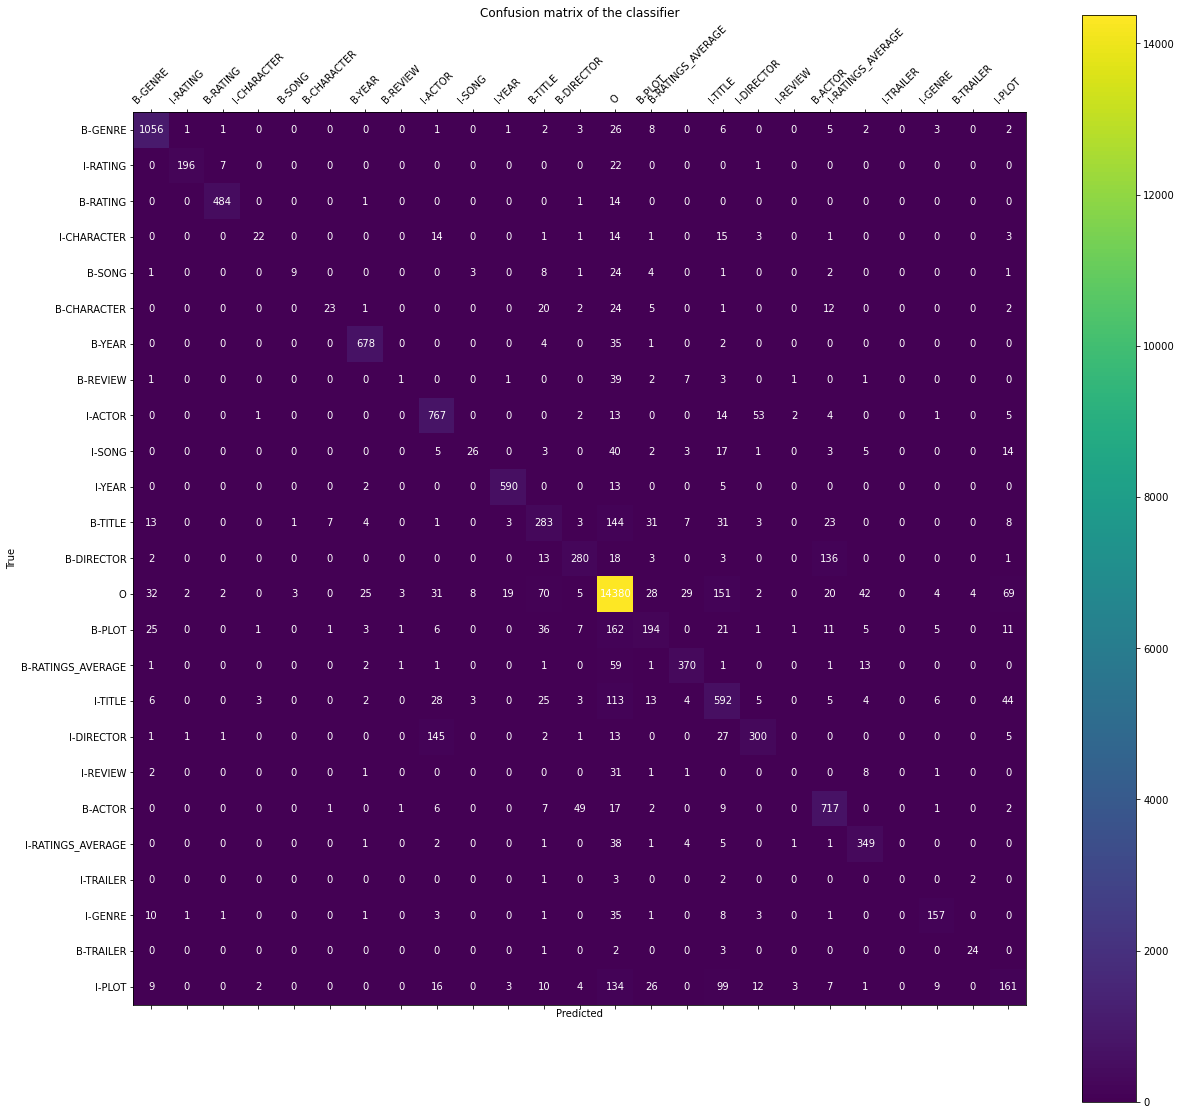

In [20]:
confusion_matrix_heatmap(y_test_full, preds_full)

#### Split Dataset Classification Report 

In [21]:
print(split_classification_report)

                   precision    recall  f1-score   support

          B-ACTOR       0.65      0.87      0.74       433
      B-CHARACTER       0.70      0.32      0.44        44
       B-DIRECTOR       0.76      0.63      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.48      0.43      0.45       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.88      0.88       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.50      0.25      0.33        20
          B-TITLE       0.66      0.35      0.46       679
        B-TRAILER       1.00      0.50      0.67        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.66      0.85      0.74       482
      I-CHARACTER       0.58      0.60      0.59        47
       I-DIRECTOR       0.76      0.62      0.69       410
          I-GENRE       0.90      1.00      0.95       

##### We can clearly see that some metrics have decreased mostly because the classifier had fewer training examples. 

#### Heat Map of Split Dataset  

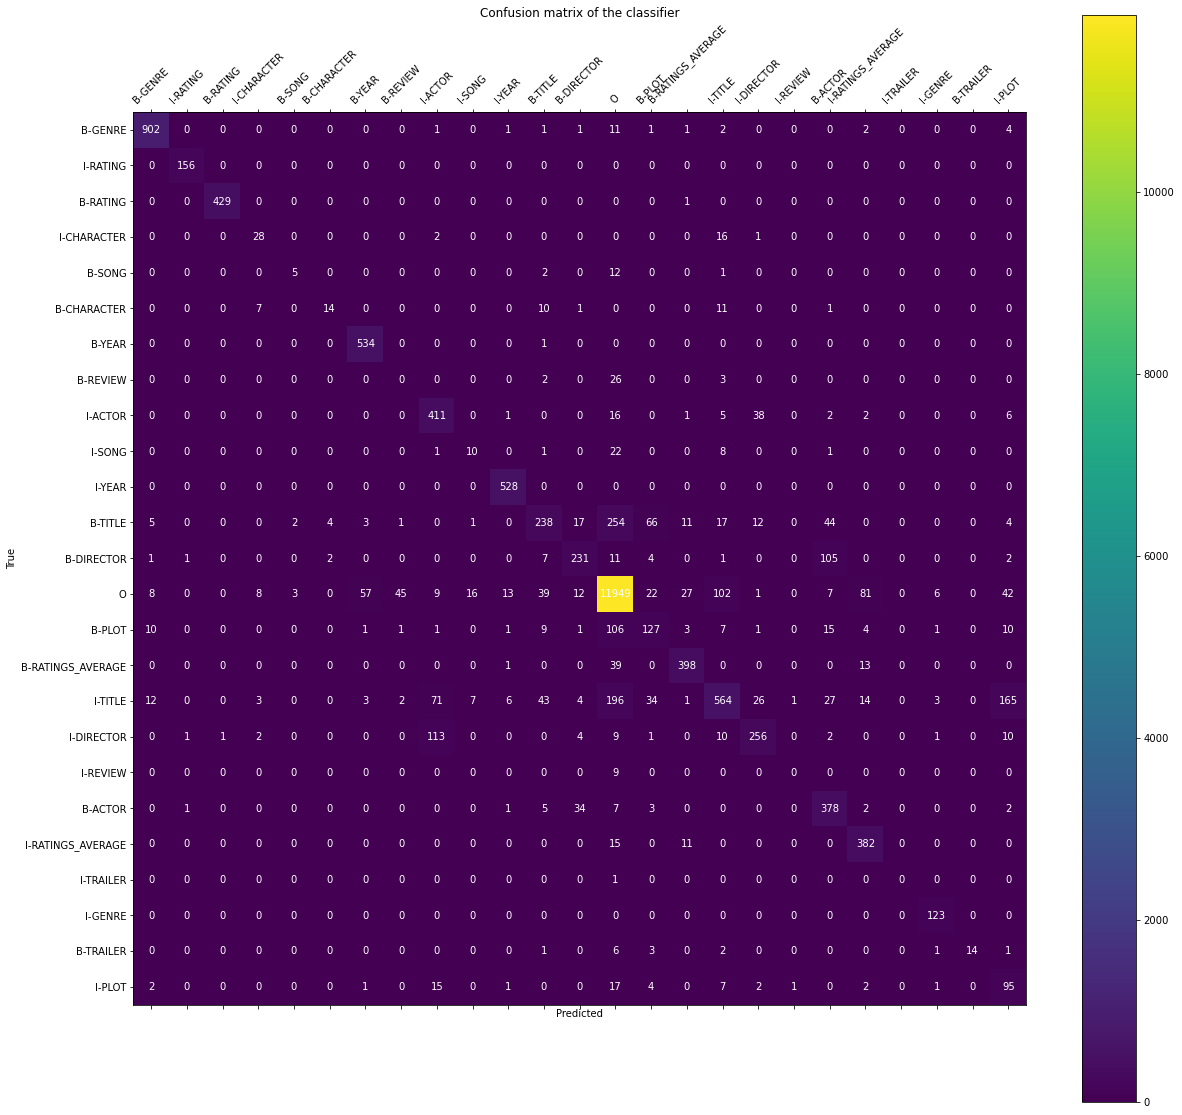

In [22]:
confusion_matrix_heatmap(y_test_split, preds_split)

## Question 2 

In [23]:
print("evaluating tagger...")
preds = []
y_test = []
fp_sent = []
fn_sent = []
low_precision_labels = ['B-REVIEW', 'I-REVIEW', 'I-PLOT', 'I-SONG', 'B-PLOT']    
for sent in development_data_split:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    for label in low_precision_labels:
        for i in range(len(sent_preds)):
            if sent_preds[i] == label and sent_preds[i] != sent_true[i]:
                s = ''
                for t in sent:
                         s += t[0] + ' '
                if s not in fp_sent:
                    fp_sent.append(s)
                    print('\n***********************\nActual Sentence:',s)
                print('Misclassified Word:',sent[i][0])
                print('Predicted:',sent_preds[i])
                print('Actual:',sent_true[i])
print("\ndone")

evaluating tagger...

***********************
Actual Sentence: what genre is the movie my date with the presidents daughter 
Misclassified Word: daughter
Predicted: I-PLOT
Actual: I-TITLE
Misclassified Word: presidents
Predicted: B-PLOT
Actual: I-TITLE

***********************
Actual Sentence: what genre is the movie the freebie 
Misclassified Word: freebie
Predicted: B-PLOT
Actual: I-TITLE

***********************
Actual Sentence: what good military movies are there about a platoon besides the movie platoon 
Misclassified Word: platoon
Predicted: B-PLOT
Actual: O

***********************
Actual Sentence: what is becoming jesse tate 
Misclassified Word: jesse
Predicted: I-PLOT
Actual: I-TITLE
Misclassified Word: tate
Predicted: I-PLOT
Actual: I-TITLE
Misclassified Word: becoming
Predicted: B-PLOT
Actual: B-TITLE

***********************
Actual Sentence: what is forbidden love about 
Misclassified Word: about
Predicted: I-PLOT
Actual: O

***********************
Actual Sentence: what is 

##### A false positive is when the classifier predicts that the data belongs to a certain class when it in fact doesn't. A low precision for a certain class indicates that there is a lot of false positives for that class. As we checked the classification report for the split dataset that we evaluated we found out that the following were the 5 classes with the lowest precision:
##### 'B-REVIEW', 'I-REVIEW', 'I-PLOT', 'I-SONG', 'B-PLOT'
##### We then printed all the sentences that were predicted to be one of these classes but weren't. We also printed the individual words in that sentence that were falsely predicted to belong to one of these classes.

## Question 3 

In [24]:
print("evaluating tagger...")
preds = []
y_test = []
fp_sent = []
fn_sent = []
low_recall_labels = ['I-SONG','B-SONG', 'B-REVIEW', 'I-REVIEW', 'I-TRAILER']     
for sent in development_data_split:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    for label in low_recall_labels:
        for i in range(len(sent_preds)):
            if sent_true[i] == label and sent_preds[i] != sent_true[i]:
                s = ''
                for t in sent:
                         s += t[0] + ' '
                if s not in fp_sent:
                    fp_sent.append(s)
                    print('\n***********************\nActual Sentence:',s)
                print('Misclassified Word:',sent[i][0])
                print('Predicted:',sent_preds[i])
                print('Actual:',sent_true[i])
print("\ndone")

evaluating tagger...

***********************
Actual Sentence: can you show me some reviews for purple rain 
Misclassified Word: reviews
Predicted: O
Actual: B-REVIEW

***********************
Actual Sentence: where can i find good reviews about the movie purple rain 
Misclassified Word: reviews
Predicted: O
Actual: B-REVIEW

***********************
Actual Sentence: what are people saying about purple rain 
Misclassified Word: people
Predicted: O
Actual: B-REVIEW
Misclassified Word: saying
Predicted: O
Actual: I-REVIEW

***********************
Actual Sentence: could you show me a website with detailed reviews of purple rain 
Misclassified Word: reviews
Predicted: O
Actual: B-REVIEW

***********************
Actual Sentence: can you let me know what reviews people of my age group gave for purple rain 
Misclassified Word: reviews
Predicted: O
Actual: B-REVIEW

***********************
Actual Sentence: what were the reviews like for purple rain 
Misclassified Word: reviews
Predicted: O
Actua

##### A false negative is when the classifier predicts that the data doesn't belongs to a certain class when it in fact does. A low recall for a certain class indicates that there is a lot of false negatives for that class. As we checked the classification report for the split dataset that we evaluated we found out that the following were the 5 classes with the lowest recall:
##### 'I-SONG','B-SONG', 'B-REVIEW', 'I-REVIEW', 'I-TRAILER'
##### We then printed all the sentences that were predicted to be one of the other classes but were among these. We also printed the individual words in that sentence that were falsely predicted to belong to one of the other classes.

### For above two questions we saw that some classes had really low precision and/or recall. We need to add features like increasing the length of suffixes, adding prefixes, annotating the lower case of words, etc. We need to make the relationship between words more apparent. This is exactly what's been done in Question 5 which helped improve our overall metrics.

## Question 4 

###### Please note that a new dataset is created again by extracting data from the files. This is done to avoid any previous preprocessed residue data interfering with the results.

In [25]:
import os
import sys
from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np
import re
import unicodedata

In [26]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []
    current_sent = []
    for line in f:
        if line == "\n":
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [27]:
file_data_train = get_raw_data_from_bio_file("engtrain.bio.txt")
from sklearn.model_selection import train_test_split
train_data_new, development_data_new = train_test_split(file_data_train, train_size=0.8, shuffle=False)

In [28]:
print(file_data_train[0])
print(train_data_new[0])
print(development_data_new[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('five', 'B-RATINGS_AVERAGE'), ('star', 'O'), ('rated', 'O'), ('thriller', 'B-GENRE'), ('directed', 'O'), ('by', 'O'), ('dover', 'B-DIRECTOR'), ('koshashvili', 'I-DIRECTOR'), ('is', 'O'), ('unrated', 'B-RATING')]


In [29]:
print('Full Data:')
print(len(file_data_train), "instances")
print(sum([len(sent) for sent in file_data_train]), "words")
print('Split training Data:')
print(len(train_data_new), "instances")
print(sum([len(sent) for sent in train_data_new]), "words")
print('Split test Data:')
print(len(development_data_new), "instances")
print(sum([len(sent) for sent in development_data_new]), "words")

Full Data:
9775 instances
99491 words
Split training Data:
7820 instances
79266 words
Split test Data:
1955 instances
20225 words


In [30]:
def preProcess(example):
    preprocessed_example = []
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    actualWords = []    
    for boi_with_word in example: 
        actualWords.append(boi_with_word[0])
    posTaggedWords = posttagger.tag(actualWords)     
    for i in range(len(posTaggedWords)):
        str1 = ''
        str1 += posTaggedWords[i][0] + '@' + posTaggedWords[i][1]
        finalResult = tuple([str1,example[i][1]])  
        preprocessed_example.append(finalResult)
    return preprocessed_example  

##### Here we extracted each word from each sentence and assigned the proper POS Tag using cr_pos tagger file that we had. We then concatenated the actual word with it's corresponding POS tag while retaining the IOB tag as label. We will use this concatenated string to get the features.

In [31]:
train_data_split = [preProcess(example) for example in train_data_new]

In [32]:
print(train_data_split[0])

[('what@WP', 'O'), ('movies@VBZ', 'O'), ('star@NNP', 'O'), ('bruce@NNP', 'B-ACTOR'), ('willis@NNP', 'I-ACTOR')]


In [33]:
def get_features(tokens, idx):
    feature_list = []
    token = tokens[idx] 
    pos_word_token = token.split('@')
    actual_word = pos_word_token[0]
    pos_tag = pos_word_token[1]
    if not token:
        return feature_list
    # Capitalization
    if actual_word[0].isupper():
        feature_list.append("CAPITALIZATION")
    #Number
    _pattern = re.compile(r"\d")  # to recognize numbers/digits
    if re.search(_pattern, actual_word) is not None:
        feature_list.append("HAS_NUM")
    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in actual_word):
        feature_list.append("PUNCTUATION")
    #Suffix up to length 3
    if len(actual_word) > 1:
        feature_list.append("SUF_" + actual_word[-1:])
    if len(actual_word) > 2:
        feature_list.append("SUF_" + actual_word[-2:])
    if len(actual_word) > 3:
        feature_list.append("SUF_" + actual_word[-3:])
    # Annotating all the words
    feature_list.append("WORD_" + actual_word)
    # Annotating all the POS Tags
    feature_list.append("POS_" + pos_tag)
    return feature_list

##### Above, we have not made any changes to the features. We have kept the same as we did for training using only IOB tags. 

In [34]:
TAGGER_PATH = "crf_nlu_split_pos.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
print("training tagger...")
ct.train(train_data_split, TAGGER_PATH)
print("done")

training tagger...
done


In [35]:
development_data_split =[preProcess(example) for example in development_data_new]

In [36]:
print("testing tagger...")
preds_split_pos = []
y_test_split_pos = []
for sent in development_data_split:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_split_pos.extend(sent_preds)
    y_test_split_pos.extend(sent_true)
print("done")

testing tagger...
done


In [37]:
POSSplitReport = classification_report(y_test_split_pos, preds_split_pos,zero_division=1)
print(POSSplitReport)

                   precision    recall  f1-score   support

          B-ACTOR       0.64      0.85      0.73       433
      B-CHARACTER       0.68      0.34      0.45        44
       B-DIRECTOR       0.75      0.64      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.46      0.48      0.47       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.89      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.54      0.35      0.42        20
          B-TITLE       0.68      0.34      0.45       679
        B-TRAILER       1.00      0.54      0.70        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.65      0.83      0.73       482
      I-CHARACTER       0.55      0.60      0.57        47
       I-DIRECTOR       0.75      0.64      0.69       410
          I-GENRE       0.91      1.00      0.95       

##### Above we saw that there's a slight increase in all the metrics from the previous classification report where we did not use POS Tags.

In [38]:
def confusion_matrix_heatmap(y_test, preds):
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

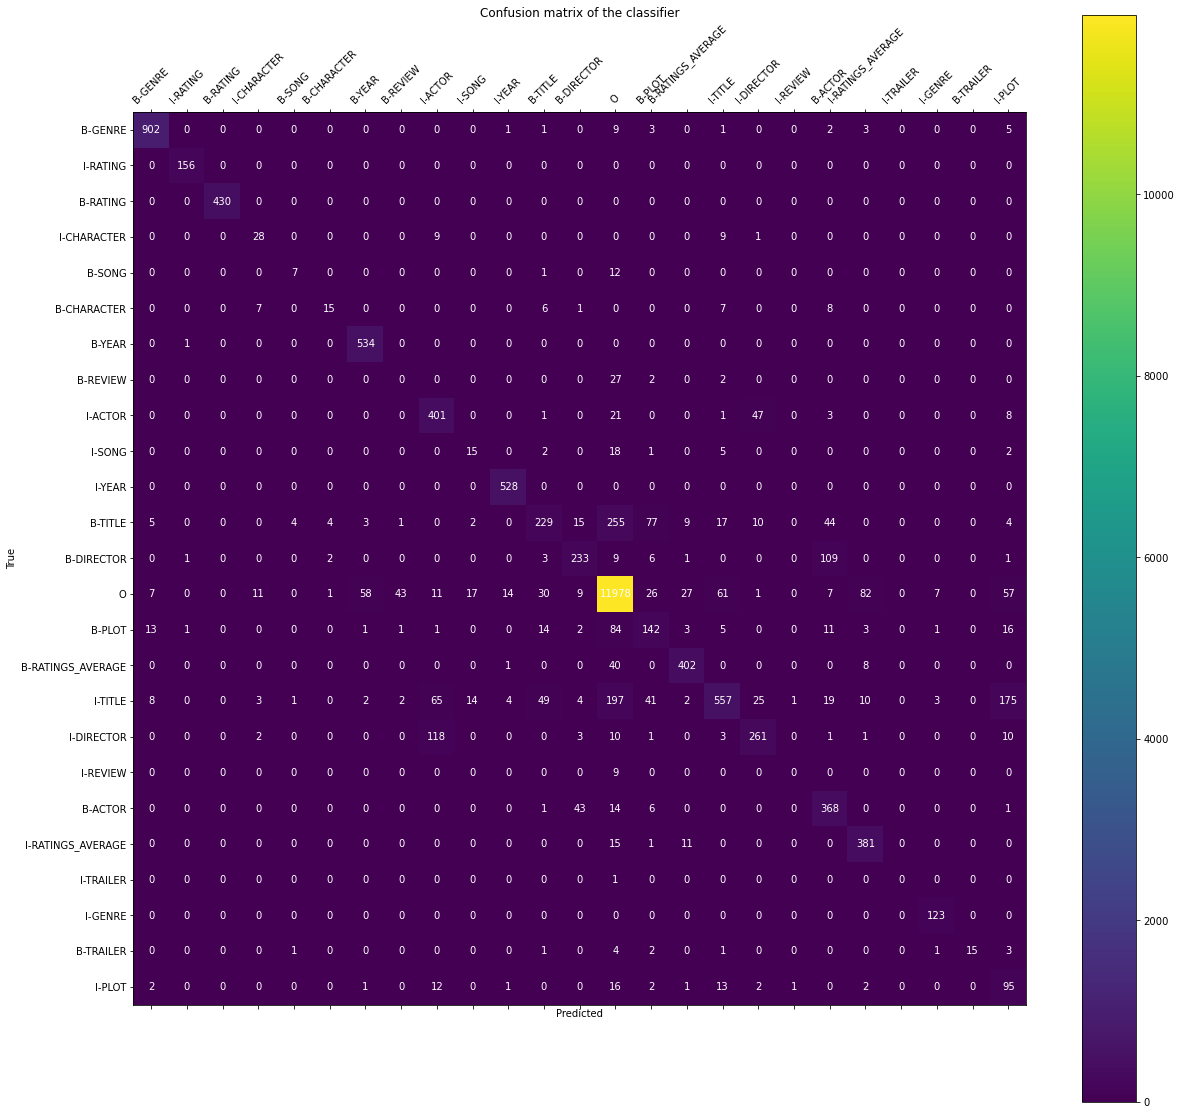

In [39]:
confusion_matrix_heatmap(y_test_split_pos, preds_split_pos)

## Question 5 

###### Please note that a new dataset is created again by extracting data from the files. This is done to avoid any previous preprocessed residue data interfering with the results.

In [40]:
import os
import sys
from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np
import re
import unicodedata

In [41]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []
    current_sent = []
    for line in f:
        if line == "\n":
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [42]:
file_data_train = get_raw_data_from_bio_file("engtrain.bio.txt")
from sklearn.model_selection import train_test_split
train_data_new, development_data_new = train_test_split(file_data_train, train_size=0.8, shuffle=False)

In [43]:
print(file_data_train[0])
print(train_data_new[0])
print(development_data_new[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
[('what', 'O'), ('five', 'B-RATINGS_AVERAGE'), ('star', 'O'), ('rated', 'O'), ('thriller', 'B-GENRE'), ('directed', 'O'), ('by', 'O'), ('dover', 'B-DIRECTOR'), ('koshashvili', 'I-DIRECTOR'), ('is', 'O'), ('unrated', 'B-RATING')]


In [44]:
print('Full Data:')
print(len(file_data_train), "instances")
print(sum([len(sent) for sent in file_data_train]), "words")
print('Split training Data:')
print(len(train_data_new), "instances")
print(sum([len(sent) for sent in train_data_new]), "words")
print('Split test Data:')
print(len(development_data_new), "instances")
print(sum([len(sent) for sent in development_data_new]), "words")

Full Data:
9775 instances
99491 words
Split training Data:
7820 instances
79266 words
Split test Data:
1955 instances
20225 words


In [45]:
def preProcess(example):
    preprocessed_example = []
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    actualWords = []    
    for boi_with_word in example: 
        actualWords.append(boi_with_word[0])
    posTaggedWords = posttagger.tag(actualWords)     
    for i in range(len(posTaggedWords)):
        str1 = ''
        str1 += posTaggedWords[i][0] + '@' + posTaggedWords[i][1]
        finalResult = tuple([str1,example[i][1]])  
        preprocessed_example.append(finalResult)
    return preprocessed_example  

In [46]:
train_data_split = [preProcess(example) for example in train_data_new]

In [47]:
print(train_data_split[0])

[('what@WP', 'O'), ('movies@VBZ', 'O'), ('star@NNP', 'O'), ('bruce@NNP', 'B-ACTOR'), ('willis@NNP', 'I-ACTOR')]


In [48]:
def get_features(tokens, idx):
    feature_list = []
    token = tokens[idx] 
    pos_word_token = token.split('@')
    actual_word = pos_word_token[0]
    pos_tag = pos_word_token[1]
    if not token:
        return feature_list
    # Capitalization
    if actual_word[0].isupper():
        feature_list.append("CAPITALIZATION")
    #Number
    _pattern = re.compile(r"\d")  # to recognize numbers/digits
    if re.search(_pattern, actual_word) is not None:
        feature_list.append("HAS_NUM")
    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in actual_word):
        feature_list.append("PUNCTUATION")
    #Suffix up to length 3
    if len(actual_word) > 1:
        feature_list.append("SUF_" + actual_word[-1:])
    if len(actual_word) > 2:
        feature_list.append("SUF_" + actual_word[-2:])
    if len(actual_word) > 3:
        feature_list.append("SUF_" + actual_word[-3:])
    # Trying with Length 4
    if len(actual_word) > 4:
        feature_list.append("SUF_" + actual_word[-4:])    
    # Getting the previous word and its corresponding POS tag
    if idx-1 >= 0:
        previous_token = tokens[idx-1] 
        new_tokens = previous_token.split('@')
        prev_word = new_tokens[0]
        prev_tag = new_tokens[1]
        # Annotating the previous actual word
        feature_list.append("PREV_WORD_" + prev_word)
        # Annotating the previous actual word's POS Tag
        feature_list.append("PREV_POS_" + prev_tag) 
     # Getting next word and its corresponding POS tag
    if idx+1 < len(tokens):
        next_token = tokens[idx+1] 
        new_tokens = next_token.split('@')
        next_word = new_tokens[0]
        next_tag = new_tokens[1]
        # Annotating the next actual word
        feature_list.append("NEXT_WORD_" + next_word)
        # Annotating the next actual word's POS Tag
        feature_list.append("NEXT_POS_" + next_tag)
    # Prefix up to length 3
    if len(actual_word) > 2:
        feature_list.append("PRE_" + actual_word[:2])
    if len(actual_word) > 3:
        feature_list.append("PRE_" + actual_word[:3])
    # Trying with Length 4
    if len(actual_word) > 4:
        feature_list.append("PRE_" + actual_word[:4]) 
#     # Annotating all the words
    feature_list.append("WORD_" + actual_word)
    # Annotating all the POS Tags for the corresponding actual word
    feature_list.append("POS_" + pos_tag)
    #Lowercase words as features
    feature_list.append("LOW_WORD_" + actual_word.lower())
#     #Hyphenated
    if '-' in actual_word:
        feature_list.append("HAS_HYPHEN")
    return feature_list

##### Here we have added some more features to increase the macro average f-score:
##### 1) PREV_WORD_ & PREV_POS_
##### We annotate the previous word and the respective POS tag with respect to the current word to establish a relationship between them. Just adding this did not make any difference in the macro average of fscore
##### 2) NEXT_WORD_ & NEXT_POS_
##### We annotate the next word and the respective POS tag with respect to the current word to establish a relationship between them. Adding this in addition to the previous word and pos tag feature, we increase the macro average f-score to 0.65
##### 3) PRE_ (upto length 3) and upto length 4 for both PRE_ and SUF_
##### All words' prefixes with length upto 3 are annotated using 'PRE_'. Using this in addition to the previous two features we increase the macro average f score to 0.69. Trying upto length 4 for both SUF_ and PRE_ increases it slightly to 0.70
##### 4) HAS_HYPHEN
##### All strings with hyphens in them are annotated using 'HAS_HYPHEN'. Makes no change in micro average.
##### 4) LOW_WORD_
##### All words are converted to lower case and annotated with 'LOW_WORD_'. This brings all the same words with different type of letters (Capital and small) on the same level. It increases the macro average f-score to 0.71.

In [49]:
TAGGER_PATH = "crf_nlu_split_pos_improved.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
print("training tagger...")
ct.train(train_data_split, TAGGER_PATH)
print("done")

training tagger...
done


In [50]:
development_data_split =[preProcess(example) for example in development_data_split]

In [51]:
print("testing tagger...")
preds_split_pos_improved = []
y_test_split_pos_improved = []
for sent in development_data_split:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_split_pos_improved.extend(sent_preds)
    y_test_split_pos_improved.extend(sent_true)
print("done")

testing tagger...
done


In [52]:
POSSplitReport = classification_report(y_test_split_pos_improved,preds_split_pos_improved,zero_division=1)
print(POSSplitReport)

                   precision    recall  f1-score   support

          B-ACTOR       0.86      0.95      0.90       433
      B-CHARACTER       0.79      0.34      0.48        44
       B-DIRECTOR       0.95      0.91      0.93       365
          B-GENRE       0.98      0.98      0.98       927
           B-PLOT       0.81      0.85      0.83       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.95      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.73      0.40      0.52        20
          B-TITLE       0.84      0.64      0.73       679
        B-TRAILER       0.83      0.36      0.50        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.85      0.93      0.89       482
      I-CHARACTER       0.62      0.32      0.42        47
       I-DIRECTOR       0.95      0.89      0.92       410
          I-GENRE       0.93      1.00      0.96       

In [53]:
def confusion_matrix_heatmap(y_test, preds):
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

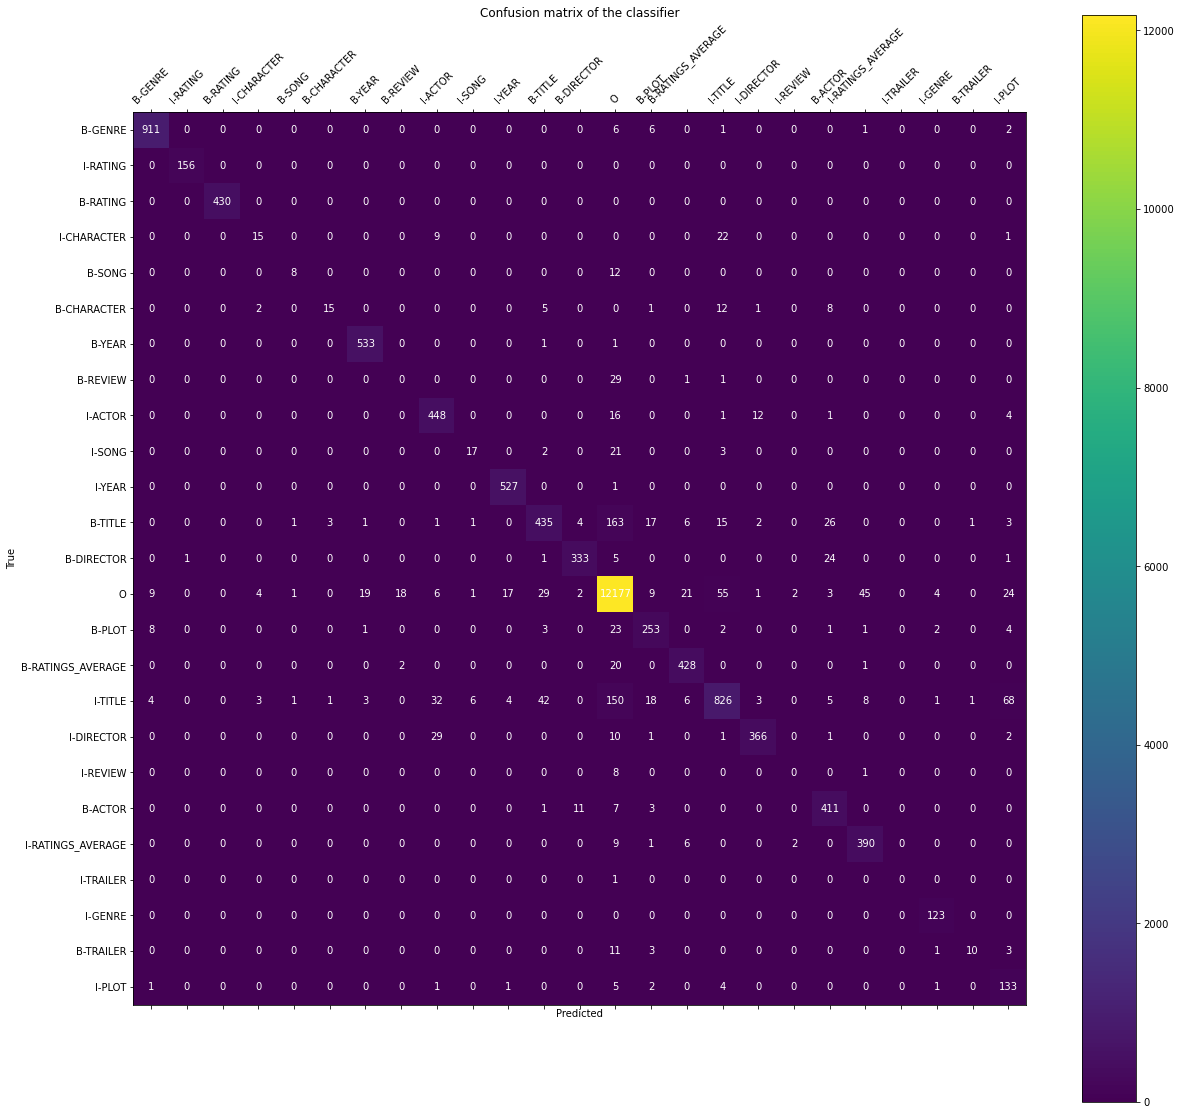

In [54]:
confusion_matrix_heatmap(y_test_split_pos_improved, preds_split_pos_improved)

### Trying the improved version on Full Training Set 

In [55]:
train_data_full = [preProcess(example) for example in file_data_train]

In [56]:
TAGGER_PATH = "crf_nlu_full_pos_improved.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
print("training tagger...")
ct.train(train_data_full, TAGGER_PATH)
print("done")

training tagger...
done


In [57]:
ct = CRFTagger(feature_func=get_features)
ct.set_model_file(TAGGER_PATH)
file_data_test = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data_full = [preProcess(example) for example in file_data_test]
print(len(test_data_full), "instances")
print(sum([len(sent) for sent in test_data_full]), "words")

2443 instances
24686 words


In [58]:
print("testing tagger...")
preds_full_pos_improved = []
y_test_full_pos_improved = []
for sent in test_data_full:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_full_pos_improved.extend(sent_preds)
    y_test_full_pos_improved.extend(sent_true)
print("done")

testing tagger...
done


In [59]:
POSFullReport = classification_report(y_test_full_pos_improved,preds_full_pos_improved,zero_division=1)
print(POSFullReport)

                   precision    recall  f1-score   support

          B-ACTOR       0.89      0.94      0.92       812
      B-CHARACTER       0.82      0.51      0.63        90
       B-DIRECTOR       0.91      0.84      0.87       456
          B-GENRE       0.93      0.95      0.94      1117
           B-PLOT       0.71      0.65      0.68       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.93      0.88      0.91       451
         B-REVIEW       0.36      0.09      0.14        56
           B-SONG       0.75      0.56      0.64        54
          B-TITLE       0.76      0.77      0.76       562
        B-TRAILER       0.81      0.83      0.82        30
           B-YEAR       0.96      0.94      0.95       720
          I-ACTOR       0.88      0.94      0.91       862
      I-CHARACTER       0.74      0.41      0.53        75
       I-DIRECTOR       0.91      0.84      0.87       496
          I-GENRE       0.86      0.71      0.78       

##### We finally use this improved version of classifier on the whole dataset. As we can see 0.73 macro average f score which is good.

In [60]:
def confusion_matrix_heatmap(y_test, preds):
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

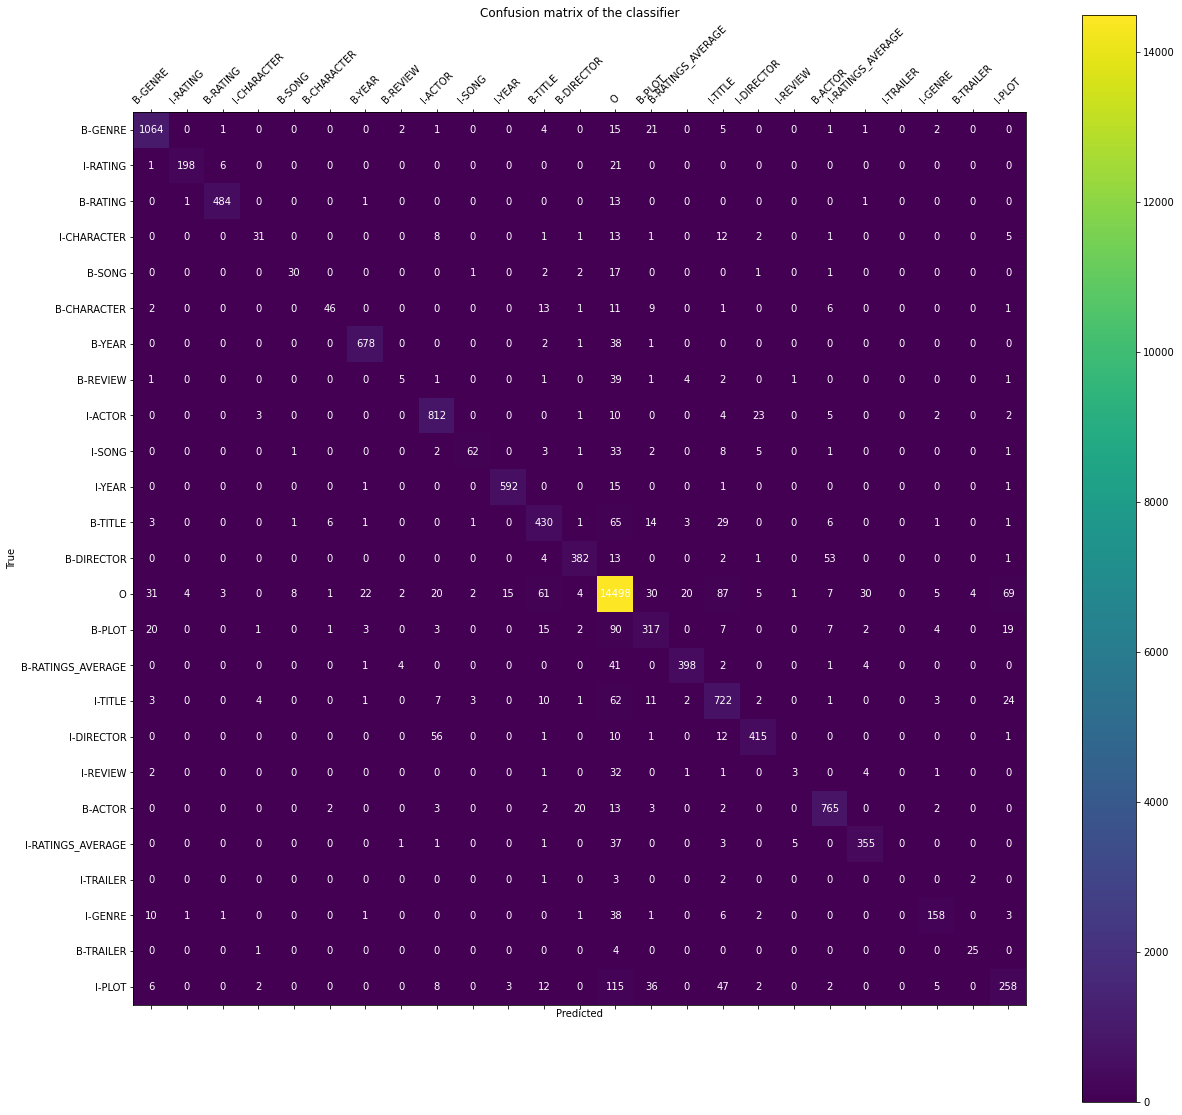

In [61]:
confusion_matrix_heatmap(y_test_full_pos_improved, preds_full_pos_improved)